# Spindles and the Hirsch conjecture I

In this tutorial, we will explore a particular spindle that is known from theory to have
an interesting property: Its apices are far away from each other in the graph of the spindle.
This property made it possible to disprove a long-standing conjecture in polyhedral theory,
the so-called *Hirsch conjecture*. Even though the focus of this tutorial is on a thorough
analysis of the special spindle, we will showcase some more advanced functionalities
and customization options of *Spindles.jl* along the way.
For the basic usage, please read this tutorial first.

## The Hirsch conjecture

The [Hirsch conjecture](https://en.wikipedia.org/wiki/Hirsch_conjecture) for polytopes
stated that any two vertices of a $d$-dimensional polytope with $f$ facets can be connected
by a path of at most $f-d$ edges. It was disproved in 2010 when Francisco Santos found a
[construction](https://arxiv.org/abs/1006.2814) that produces counterexamples from spindles
with a special property: the length of a shortest path between the apices
(called the *length* of the spindle) must be strictly greater than the dimension.

Santos' original counterexample from 2010 is based on a 5-dimensional spindle with 48 facets,
for which the shortest path between the apices is of length 6. A minimal inequality description
of this spindle (see Table 1 in Santos' [paper](https://arxiv.org/pdf/1006.2814)) can be found
in the file `s-48-5.txt` located in the `examples` folder beneath the package root directory `Spindles`.

## Reading a spindle from a file

The data can be read from the file using the function `readineq` as follows.

In [1]:
using Spindles
A, b, labels = readineq("../../../examples/s-48-5.txt", Int);

The function returns not only the coefficient matrix `A` and vector of
right-hand sides `b` of the description $Ax \le b$

In [2]:
[A b]

48×6 Matrix{Rational{Int64}}:
  1   18    0    0    0  1
  1  -18    0    0    0  1
  1    0   18    0    0  1
  1    0  -18    0    0  1
  1    0    0   45    0  1
  1    0    0  -45    0  1
  1    0    0    0   45  1
  1    0    0    0  -45  1
  1   15   15    0    0  1
  1  -15   15    0    0  1
  ⋮                      ⋮
 -1  -30  -30    0    0  1
 -1   40    0   10    0  1
 -1   40    0  -10    0  1
 -1  -40    0   10    0  1
 -1  -40    0  -10    0  1
 -1    0   40    0   10  1
 -1    0   40    0  -10  1
 -1    0  -40    0   10  1
 -1    0  -40    0  -10  1

but also a label for each inequality:

In [3]:
labels

48-element Vector{String}:
 "1⁺"
 "1⁻"
 "2⁺"
 "2⁻"
 "3⁺"
 "3⁻"
 "4⁺"
 "4⁻"
 "5⁺"
 "5⁻"
 ⋮
 "20⁻"
 "21⁺"
 "21⁻"
 "22⁺"
 "22⁻"
 "23⁺"
 "23⁻"
 "24⁺"
 "24⁻"

> **Note**
>
> Even though we use the same set of labels as Santos in his [paper](https://arxiv.org/pdf/1006.2814),
> the assignment to the rows of `A` is different.

The resulting spindle `s` has

In [4]:
s = Polytope(A, b)
nvertices(s)

322

vertices and its apices are

In [5]:
apx = apices(s)
collect(vertices(s))[apx]

2-element Vector{Vector{Rational{Int64}}}:
 [-1, 0, 0, 0, 0]
 [1, 0, 0, 0, 0]

The distance between them in the graph of `s` is indeed 6:

In [6]:
dist(s, apx...)

6

Note that both apices are highly degenerate:

In [7]:
using Graphs: degree
degree(graph(s), apx)

2-element Vector{Int64}:
 32
 32

## Inspecting faces

The original motivation for developing *Spindles.jl* was the search for special two-dimensional faces
(or *2-faces* for short) of the spindle `s` and similar spindles.
To explain what we mean by "special", let us consider the following three facets (note that all inequalities
in the description given in `s-48-5.txt` are indeed facet-defining):

In [8]:
face = [29, 37, 41]
labels[face]

3-element Vector{String}:
 "15⁺"
 "19⁺"
 "21⁺"

They indeed define a 2-face of `s`:

In [9]:
dim(s, face) == 2

true

To inspect `face`, we may use the `plot` command from [Plots.jl](https://github.com/JuliaPlots/Plots.jl)
to make a plot.

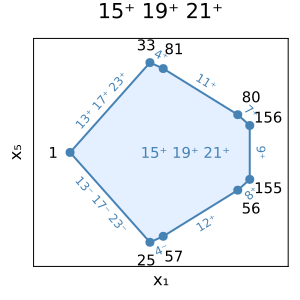

In [10]:
using Plots
plot(s, face; ineqlabels=labels)

This creates a two-dimensional projection of `face` onto the two coordinates
by which the axes are labeled above.

Each vertex is labeled by its index. Edges and the face itself get their labels from the incident facets,
since we passed the `labels` extracted above to the keyword argument `ineqlabels`. Note here that the
three facets that contain `face` are omitted from the edge labels.

We may customize the above plot even further. For example, let's add more information to the vertex labels.
To print the distances of each vertex to the two apices of `s` on a second line
beneath the vertex index, we first generate all labels in the desired format. Here, we use the format
`"dist1 | dist2"` for the second line of the label, where `dist1` and `dist2` are placeholders for the
distances to `apx[1]` and `apx[2]`, respectively.

In [11]:
dist_labels = map(1:nvertices(s)) do v
    "$v\n" * join(dist.(s, apx, v), " | ")
end

322-element Vector{String}:
 "1\n0 | 6"
 "2\n1 | 5"
 "3\n1 | 5"
 "4\n1 | 5"
 "5\n1 | 5"
 "6\n1 | 5"
 "7\n1 | 5"
 "8\n1 | 5"
 "9\n1 | 5"
 "10\n1 | 5"
 ⋮
 "314\n5 | 1"
 "315\n5 | 1"
 "316\n5 | 1"
 "317\n5 | 1"
 "318\n5 | 1"
 "319\n5 | 1"
 "320\n5 | 1"
 "321\n5 | 1"
 "322\n5 | 1"

> **Julia syntax**
>
> ````julia
> dist.(s, apx, v)
> ````
> is a shorthand for
> ````julia
> [dist(s, a, v) for a in apx]
> ````

Our custom vertex labels can now be passed to `plot` as follows:

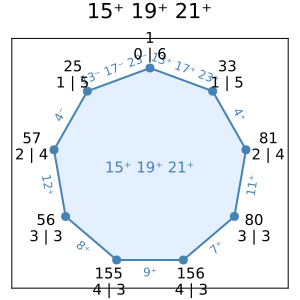

In [12]:
plot(s, face; ineqlabels=labels, vertexlabels=dist_labels, usecoordinates=false)

Note here that the (optional) additional argument `usecoordinates=false` changed the plot mode
to a (combinatorial) drawing of the graph of the face `15⁺ 19⁺ 21⁺` rather than a planar projection of
its true coordinates as above.

## A good 2-face

Next, let's take a closer look at our custom labels in the plot that we just generated.
For each vertex of the face, the sum of both distances on the second line of its label must be at least 6,
since we know that there is no shorter path between the apices. In fact, there are (at least) two such
shortest paths that traverse parts of the face:
One of the apices of `s` actually is a vertex of the face, namely the first apex

In [13]:
apx

2-element Vector{Int64}:
   1
 100

at index `1`. Start from there and take
3 steps to either `56` or `80`. Both vertices are at distance 3 from the second apex,
as their labels tell us.
The only two vertices that are not visited on either of those two paths are `155` and `156`,
and they are also at distance 3 from the second apex.

So among the vertices of the face `15⁺ 19⁺ 21⁺`, there are two special subsets:
One subset of vertices, let us call it $V_1$, is "close" to the first apex
(namely, take $V_1$ to be the apex `1 ` itself). The other subset $V_2$
(the subset consisting of `56`, `155`, `156`, and `80`) is disjoint from the
first one, and each vertex in $V_2$ is "close" to the second apex . Here, "close" means that
if we pick two arbitrary vertices, one from each subset, then the sum of their distances
to the respectively closest apex is at most some given number $k$.
In our case, any $k \ge 3$ would work for this definition of being "close", since
the distance of $V_1$ to `apx[1]` is 0 and that of any vertex in $V_2$ to `apx[2]` is 3.

Let's visualize the two sets $V_1$ and $V_2$. Again, we tweak the arguments passed to
`plot` and label the vertices of the face by which set they belong to. For example, this
can be achieved by

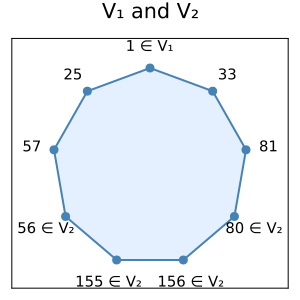

In [14]:
set_labels = map(1:nvertices(s)) do v
    if v == 1
        return "$v ∈ V₁"
    elseif v in [56, 155, 156, 80]
        return "$v ∈ V₂"
    else
        return "$v"  # default label for vertices in neither of the two sets
    end
end
plot(s, face; ineqlabels=nothing, vertexlabels=set_labels, usecoordinates=false, title="V₁ and V₂")

Note that there are exactly two edges of the face `15⁺ 19⁺ 21⁺` whose endpoints belong
to neither $V_1$ nor $V_2$ (and, hence, are only labeled by their index in the plot above). These edges are those
between `25` and `57`, and between `33` and `81`.
Let's mark them up in the plot using the keyword argument `markup_edges`:

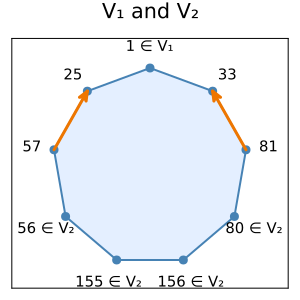

In [15]:
plot(s, face;
    ineqlabels=nothing, vertexlabels=set_labels,
    markup_edges=([25,57], [33,81]),
    usecoordinates=false, title="V₁ and V₂"
)

Not only are the two edges marked up in the plot, they are also drawn as *directed* edges now.
To see why (and how this direction is determined by `plot`), let's look at the true geometry of
the face `15⁺ 19⁺ 21⁺` again:

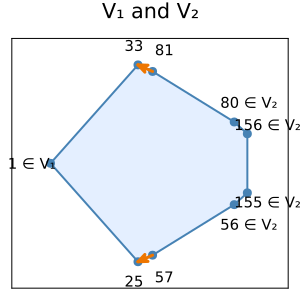

In [16]:
plot(s, face;
    ineqlabels=nothing, vertexlabels=set_labels,
    markup_edges=([25,57], [33,81]),
    usecoordinates=true, title="V₁ and V₂",
    xguide="", yguide=""  # hide axis labels
)

Now the two arrows point away from each other – this is precisely how the `plot` command decides
at which endpoints to place the arrow tips.

Yet what do these directions tell us?
To explain this, recall that each of the highlighted edges belongs to a shortest path (of length 6) between the apices of `s`.
For example, we saw above that there is path of length 3 between the second apex of `s`
(the one not contained in the face) and the vertex `156` (since `156` is in $V_2$). From `156`,
it's only 3 more edge steps to the first apex `1`.
Now imagine that we travel along the edges of this path towards `1`, and orient each edge
according to our direction of travel. Then the path becomes a sequence of steps in certain directions,
where we follow each direction as far as we can – namely, until we hit the next vertex along the path.

What happens if we choose different directions at each step? For example, suppose that we have reached `156`,
and now choose one of the two highlighted edge directions.
To visualize the situation, we need a little extra code.
First, let's define a function that, given a starting point `z` and a direction `g`,
determines how far we can walk without leaving the face. In a formula, this is the maximum number
$\mu$ for which $A(z+\mu g) \le b$ (note that the maximum is indeed finite because the spindle `s` is a polytope).

In [17]:
function maxsteplength(z, g)
    # ignore rows of A whose dot product with the given direction is <= 0
    # since the corresponding inequalities will be satisfied for any positive step length
    divpos(x, y) = y > 0 ? x/y : Inf
    minimum(divpos.(b - A * z, A * g))
end
nothing # hide

With this helper function, we can now visualize what happens after a hypothetical step along
either of the two arrows. In fact, we just add to the previous plot by using `plot!` instead of `plot`.

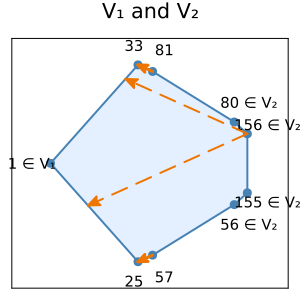

In [18]:
edges = ((81,33), (57,25))  # the two edges marked up above
source = collect(vertices(s))[156]

for (u, v) in edges
    edge_direction = collect(vertices(s))[v] - collect(vertices(s))[u]
    μ = maxsteplength(source, edge_direction)
    destination = source + μ * edge_direction

    plot!(
        # project points onto the same two coordinates (1 and 5) as the face
        [source[1], destination[1]], [source[5], destination[5]],
        seriestype=:arrow, linestyle=:dash, linewidth=2, linecolor=:darkorange2,
    )
end
current()

> **Plotting arrows**
>
> The series type `arrow` is a custom series type defined by *Spindles.jl*.

The plot above tells us that either of the two dashed arrows
(which are parallel to the marked up edges) leads us directly onto an edge that is incident with
`1`, rather than taking the "detour" along edges. In a nutshell, this is the reason why the face
`15⁺ 19⁺ 21⁺` is so interesting for analyzing paths on the spindle `s`: It allows for a "shortcut" when
steps through the interior of the face are allowed.
Note that the choice of the vertex `156` above was arbitrary.
Indeed, we could translate the tails of the two dashed arrows over to any other vertex in $V_2$
and still construct similar shortcuts on the face.

Let us call a 2-face of a spindle a *good 2-face* if it allows for such a shortcut between the apices as above
(regardless of its direction).
*Spindles.jl* provides a function `isgood2face` that tests a face for being good.

In [19]:
isgood2face(s, face, apx...)

Spindles.FaceState(true, [29, 37, 41], ([25, 57], [81, 33]), ([1], [56, 155, 156, 80]))

The result is wrapped in a bespoke data type called
`FaceState`. The field `good` indicates whether or not
the tested face is good, and the two vertex sets $V_1$ and $V_2$ that certify the property
of being good are stored in the field `vsets` (see also the documentation on the
`FaceState` type):

In [20]:
fstate = isgood2face(s, face, apx...)
fstate.good, fstate.vsets

(true, ([1], [56, 155, 156, 80]))

Feel free to compare the output with the sets $V_1$ and $V_2$ that we identified above.

## Finding all good 2-faces

Using the functions `facesofdim` and `isgood2face`, all good 2-faces of `s` are easily enumerated.

In [21]:
for f in sort(collect(facesofdim(s, 2)))
    if isgood2face(s, f, apx...).good
        println(join(labels[f], " "))
    end
end

3⁺ 7⁺ 9⁺
3⁺ 7⁺ 9⁻
3⁺ 8⁺ 9⁺
3⁺ 8⁺ 9⁻
3⁻ 7⁻ 10⁺
3⁻ 7⁻ 10⁻
3⁻ 8⁻ 10⁺
3⁻ 8⁻ 10⁻
4⁺ 7⁺ 11⁺
4⁺ 7⁺ 11⁻
4⁺ 7⁻ 11⁺
4⁺ 7⁻ 11⁻
4⁻ 8⁺ 12⁺
4⁻ 8⁺ 12⁻
4⁻ 8⁻ 12⁺
4⁻ 8⁻ 12⁻
15⁺ 19⁺ 21⁺
15⁺ 19⁺ 21⁻
15⁺ 20⁺ 21⁺
15⁺ 20⁺ 21⁻
15⁻ 19⁻ 22⁺
15⁻ 19⁻ 22⁻
15⁻ 20⁻ 22⁺
15⁻ 20⁻ 22⁻
16⁺ 19⁺ 23⁺
16⁺ 19⁺ 23⁻
16⁺ 19⁻ 23⁺
16⁺ 19⁻ 23⁻
16⁻ 20⁺ 24⁺
16⁻ 20⁺ 24⁻
16⁻ 20⁻ 24⁺
16⁻ 20⁻ 24⁻


In particular, for each good 2-face, there must exist paths from both apices to
some vertex on the face of total length at most 3.
Interestingly, all 2-faces of `s` that satisfy this weaker condition are good:

In [22]:
for f in sort(collect(facesofdim(s, 2)))
    min_total_length = sum(
        minimum(  # minimum distance of the apices to any vertex on the face
            dist(s, a, v) for v in incidentvertices(s, f)
        ) for a in apx
    )
    if min_total_length <= 3
        println(join(labels[f], " "), "\t", isgood2face(s, f, apx...).good)
    end
end

3⁺ 7⁺ 9⁺	true
3⁺ 7⁺ 9⁻	true
3⁺ 8⁺ 9⁺	true
3⁺ 8⁺ 9⁻	true
3⁻ 7⁻ 10⁺	true
3⁻ 7⁻ 10⁻	true
3⁻ 8⁻ 10⁺	true
3⁻ 8⁻ 10⁻	true
4⁺ 7⁺ 11⁺	true
4⁺ 7⁺ 11⁻	true
4⁺ 7⁻ 11⁺	true
4⁺ 7⁻ 11⁻	true
4⁻ 8⁺ 12⁺	true
4⁻ 8⁺ 12⁻	true
4⁻ 8⁻ 12⁺	true
4⁻ 8⁻ 12⁻	true
15⁺ 19⁺ 21⁺	true
15⁺ 19⁺ 21⁻	true
15⁺ 20⁺ 21⁺	true
15⁺ 20⁺ 21⁻	true
15⁻ 19⁻ 22⁺	true
15⁻ 19⁻ 22⁻	true
15⁻ 20⁻ 22⁺	true
15⁻ 20⁻ 22⁻	true
16⁺ 19⁺ 23⁺	true
16⁺ 19⁺ 23⁻	true
16⁺ 19⁻ 23⁺	true
16⁺ 19⁻ 23⁻	true
16⁻ 20⁺ 24⁺	true
16⁻ 20⁺ 24⁻	true
16⁻ 20⁻ 24⁺	true
16⁻ 20⁻ 24⁻	true


If you would like to explore one of the actual counterexamples to the Hirsch conjecture
that was built from a spindle like `s`, please read on here.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*